# MHKiT River Module

The following example will familiarize the user with the [MHKIT river module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.river.html) by stepping through the calculation of annual energy produced for one turbine in the Tanana River near Nenana, Alaska.  The data file used in this example is retrieved from the USGS website, a local version of the data is stored in the [\\\\MHKiT\\\\examples\\\\data](https://github.com/MHKiT-Software/MHKiT-Python/tree/main/examples/data) directory.

Start by importing the necessary python packages and MHKiT module.

In [1]:
import pandas as pd
from mhkit import river


## Test


## Importing Data from USGS
   
We will start by requesting daily discharge data from the USGS website for the Tanana River near Nenana, Alaska. The function `request_usgs_data` in the river IO module returns a Pandas DataFrame. The function requires the station number, parameter number, timeframe, and type of data. 

The station number can be found on the USGS website, though this is more difficult than searching the web for "USGS Tanana near Nenana" which should return a link to https://waterdata.usgs.gov/nwis/inventory/?site_no=15515500. This page contains an overview of the available data, including daily discharge data. 

The IEC standard recommends 10 years of daily discharge data for calculations of annual energy produced (AEP). The timeframe shows that at least 10 years of data is available. Clicking on the "Daily Data" will bring up a page that would allow the user to request data from the site. Each of the "Available Parameters" has a 5 digit code in front of it which will depend on the data type and reported units. The user at this point could use the website to download the data, however, the `request_usgs_data` function is used here.

In [2]:
# Use the requests method to obtain 10 years of daily discharge data
data = river.io.usgs.request_usgs_data(
    station="15515500",
    parameter="00060",
    start_date="2009-08-01",
    end_date="2019-08-01",
    data_type="Daily",
)

# Print data
print(data)

Data request URL:  https://waterservices.usgs.gov/nwis/dv/?format=json&sites=15515500&startDT=2009-08-01&endDT=2019-08-01&statCd=00003&parameterCd=00060&siteStatus=all
                           Discharge, cubic feet per second
2009-08-01 00:00:00+00:00                             59100
2009-08-02 00:00:00+00:00                             59700
2009-08-03 00:00:00+00:00                             56200
2009-08-04 00:00:00+00:00                             51700
2009-08-05 00:00:00+00:00                             52100
...                                                     ...
2019-07-28 00:00:00+00:00                             66000
2019-07-29 00:00:00+00:00                             63900
2019-07-30 00:00:00+00:00                             63500
2019-07-31 00:00:00+00:00                             64700
2019-08-01 00:00:00+00:00                             64600

[3653 rows x 1 columns]


The `request_usgs_data` function returned a pandas DataFrame indexed by time. For this example, the column name "Discharge, cubic feet per second" is long and therefore is renamed to "Q". Furthermore, MHKiT expects all units to be in SI so the discharge values is converted to $m^3/s$. Finally, we can plot the discharge time series.

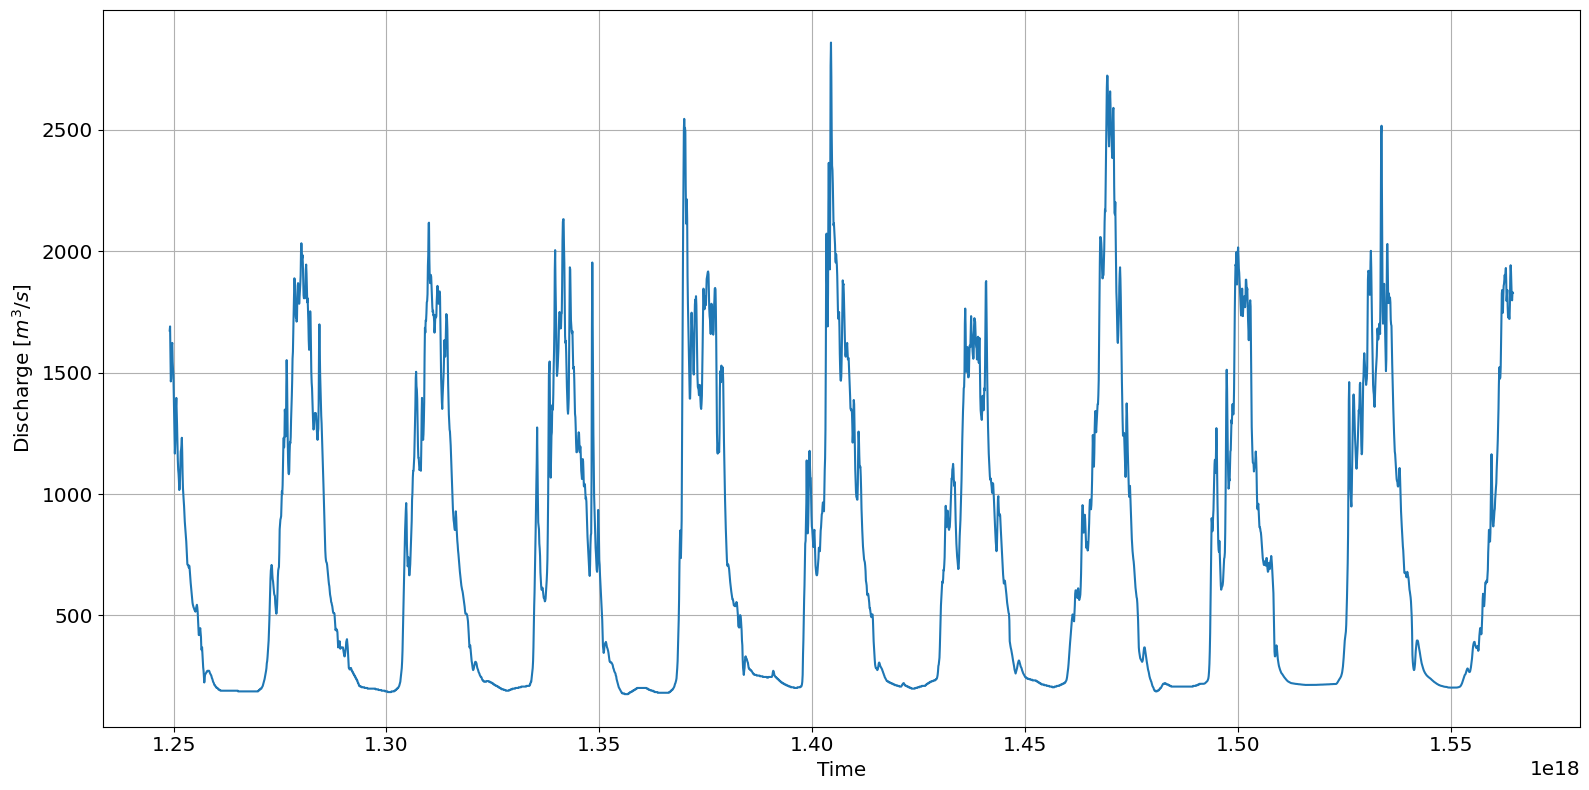

In [3]:
# Store the original DataFrame column name
column_name = data.columns[0]

# Rename to a shorter key name e.g. 'Q'
data = data.rename(columns={column_name: "Q"})

# Convert to discharge data from ft3/s to m3/s
data.Q = data.Q / (3.28084) ** 3

# Plot the daily discharge
ax = river.graphics.plot_discharge_timeseries(data.Q)

## Flow Duration Curve

The flow duration curve (FDC) is a plot of discharge versus exceedance probability which quantifies the percentage of time that the discharge in a river exceeds a particular magnitude.  The curve is typically compiled on a monthly or annual basis. 

The exceedance probability for the highest discharge is close to 0% since that value is rarely exceeded. Conversely, the lowest discharge is found closer to 100% as they are most often exceeded.

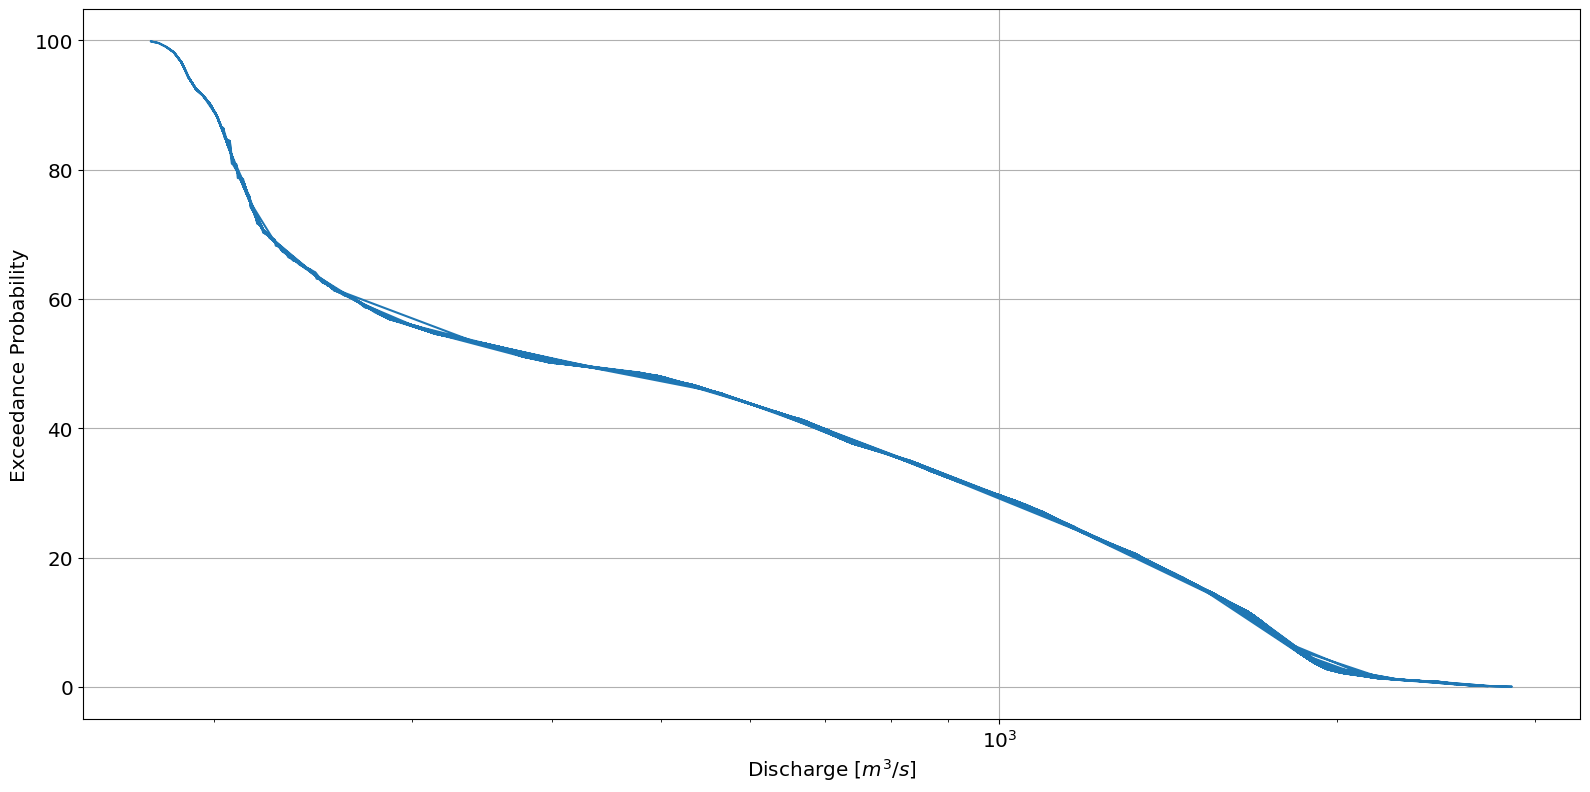

In [4]:
# Calculate exceedence probability
data["F"] = river.resource.exceedance_probability(data.Q)

# Plot the flow duration curve (FDC)
ax = river.graphics.plot_flow_duration_curve(data.Q, data.F)

## Velocity Duration Curve

At each river energy converter location we must provide a curve that relates the velocity at the turbine location to the river discharge levels. IEC 301 recommends using at least 15 different discharges and that only velocities within the turbine operating conditions need to be included.

Here we only provide 6 different discharge to velocities relationships created using a hydrological model. The data is loaded into a pandas DataFrame using the pandas method `read_csv`.

0.9971199490337135


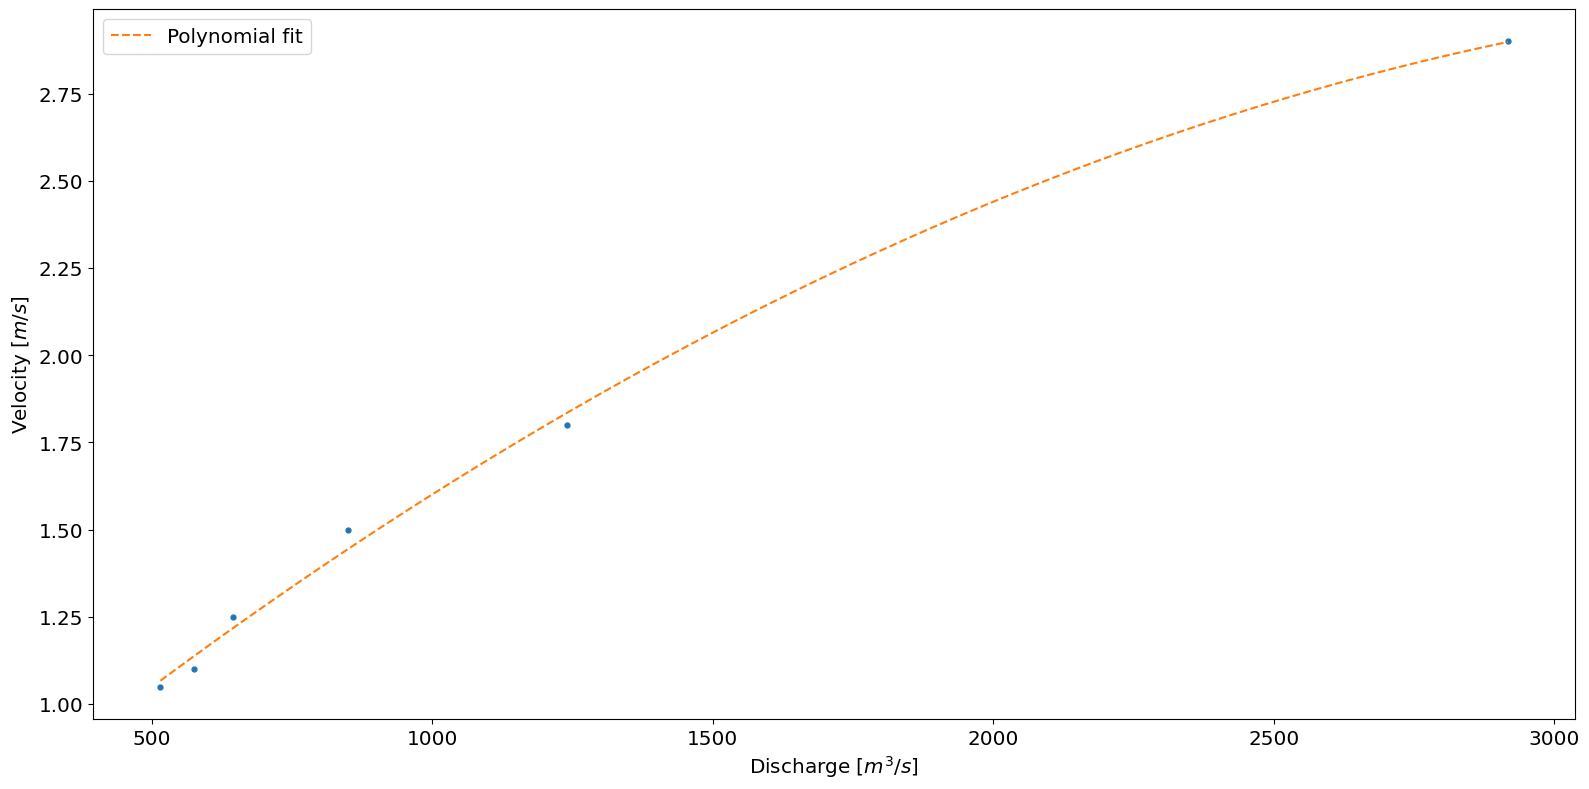

In [5]:
# Load discharge to velocity curve at turbine location
DV_curve = pd.read_csv("data/river/tanana_DV_curve.csv")

# Create a polynomial fit of order 2 from the discharge to velocity curve.
# Return the polynomial fit and and R squared value
p, r_squared = river.resource.polynomial_fit(DV_curve.D, DV_curve.V, 2)

# Plot the polynomial curve
river.graphics.plot_discharge_vs_velocity(DV_curve.D, DV_curve.V, polynomial_coeff=p)

# Print R squared value
print(r_squared)

The IEC standard recommends a polynomial fit of order 3. By changing the order above and replotting the polynomial fit to the curve data it can be seen this is not a good fit for the provided data. Therefore the order was set to 2. 

Next, we calculate velocity for each discharge using the polynomial and plot the VDC.

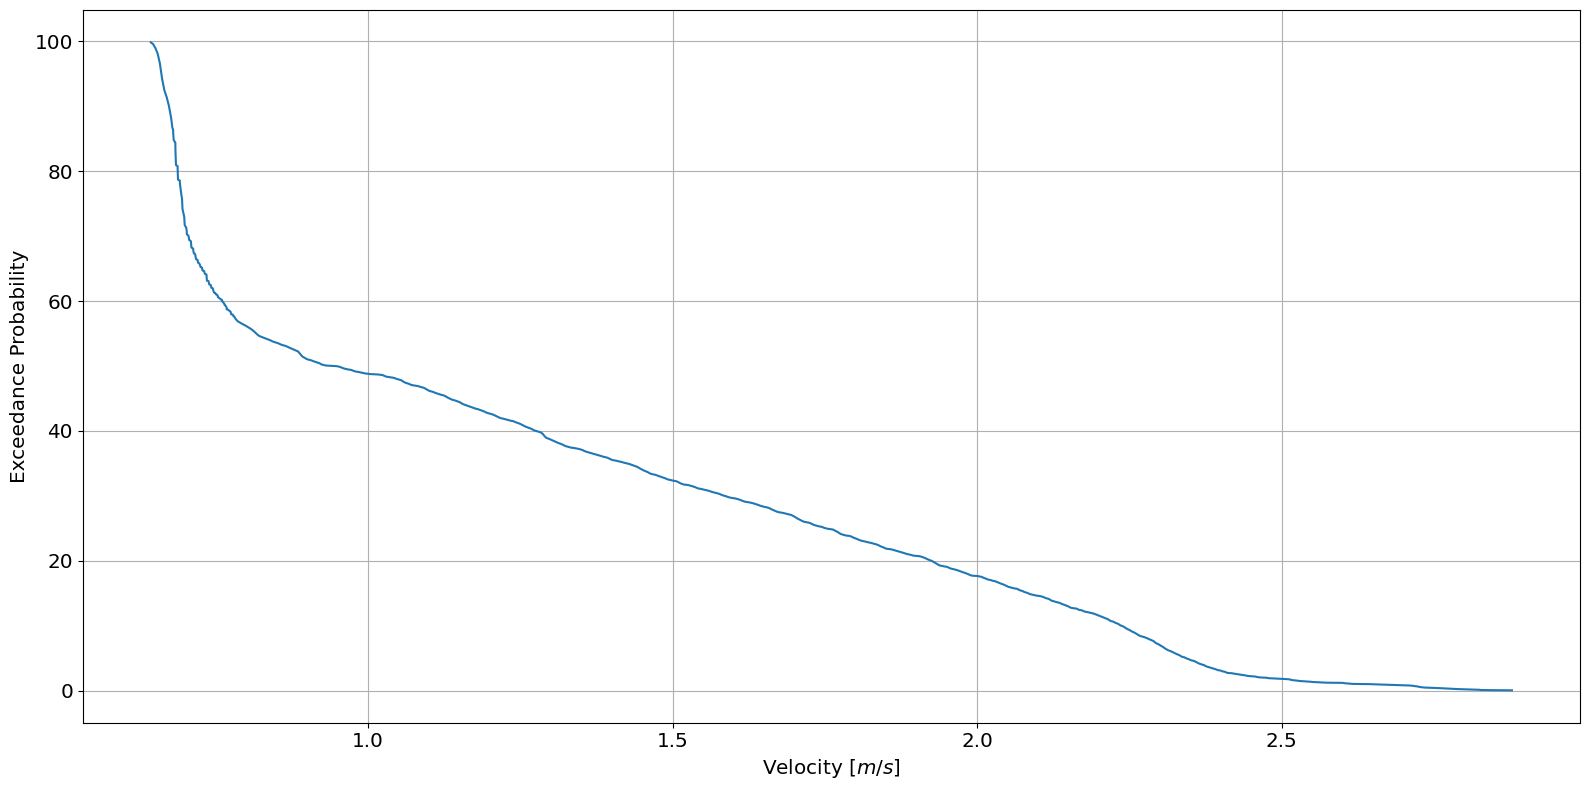

In [6]:
# Use polynomial fit from DV curve to calculate velocity ('V') from discharge at turbine location
data["V"] = river.resource.discharge_to_velocity(data.Q, p)

# Plot the velocity duration curve (VDC)
ax = river.graphics.plot_velocity_duration_curve(data.V, data.F)

## Power Duration Curve 
The power duration curve is created in a nearly identical manner to the VDC. Here, a velocity to power curve is used to create a polynomial fit. The polynomial fit is used to calculate the power produced between the turbine cut-in and cut-out velocities. The velocity to power curve data is loaded into a pandas DataFrame using the pandas method `read_csv`.

0.9994550455214498


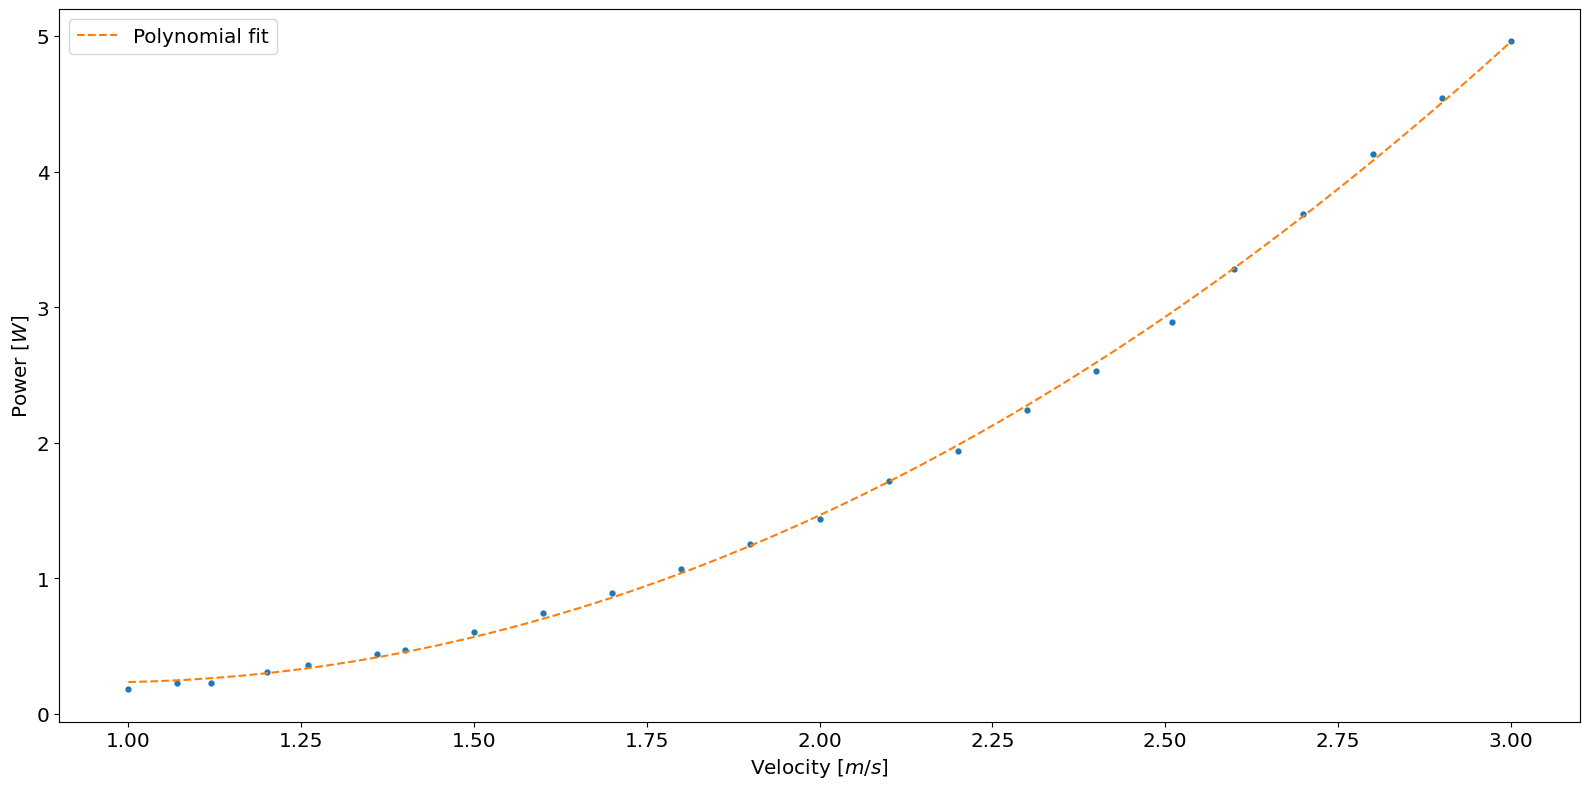

In [7]:
# Calculate the power produced from turbine velocity to power curve
VP_curve = pd.read_csv("data/river/tanana_VP_curve.csv")

# Calculate the polynomial fit for the VP curve
p2, r_squared_2 = river.resource.polynomial_fit(VP_curve.V, VP_curve.P, 2)

# Plot the VP polynomial curve
ax = river.graphics.plot_velocity_vs_power(VP_curve.V, VP_curve.P, polynomial_coeff=p2)

# Print the r_squared value
print(r_squared_2)

The second-order polynomial fits the data well. Therefore, the polynomial is used to calculate the power using the min and max of the curves velocities as the turbine operational limits.

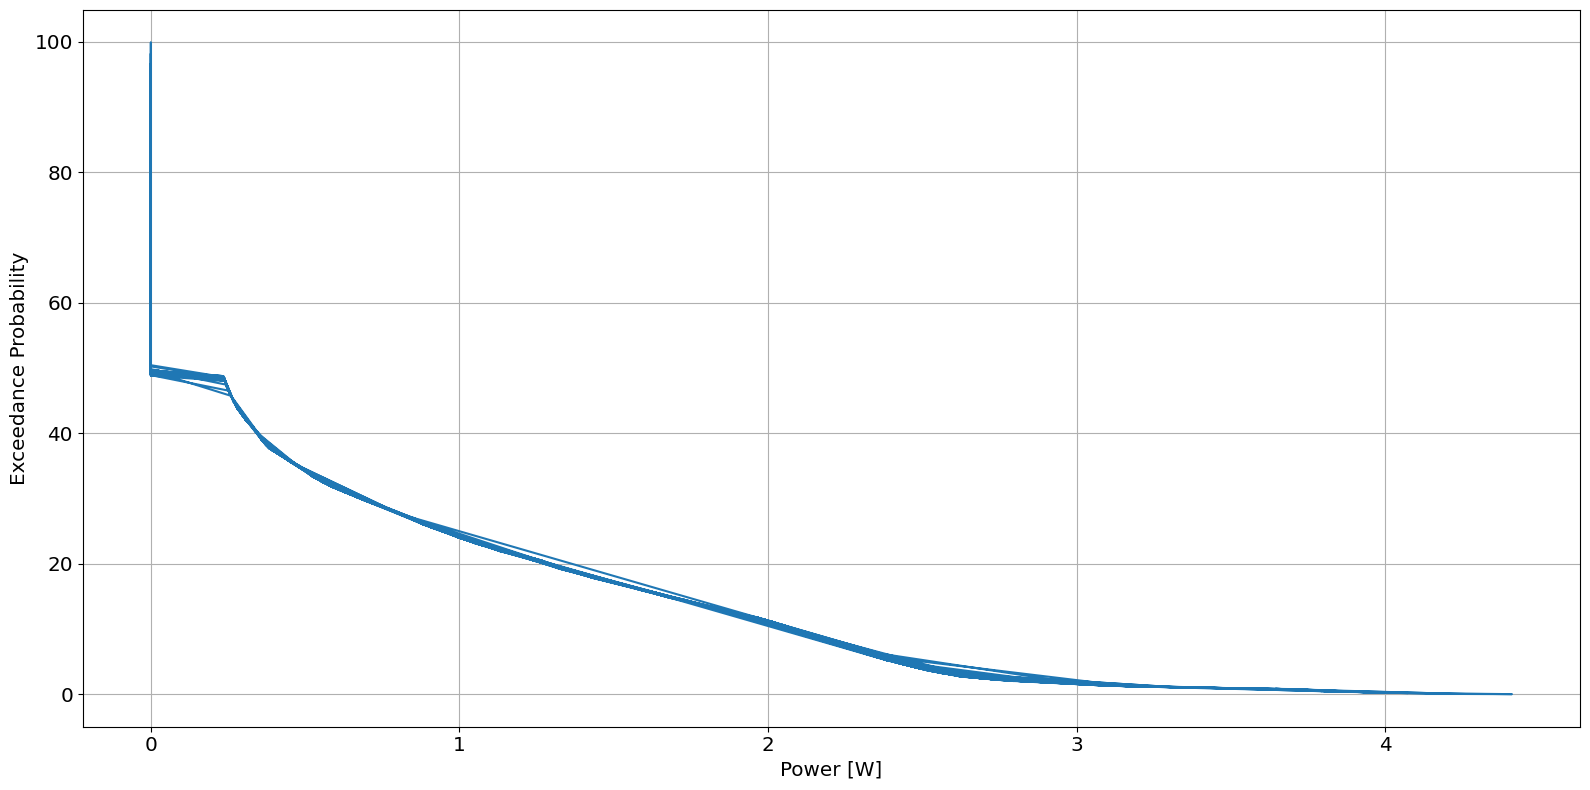

In [8]:
# Calculate power from velocity at the turbine location
data["P"] = river.resource.velocity_to_power(
    data.V,
    polynomial_coefficients=p2,
    cut_in=VP_curve.V.min(),
    cut_out=VP_curve.V.max(),
)
# Plot the power duration curve
ax = river.graphics.plot_power_duration_curve(data.P, data.F)

## Annual Energy Produced
Finally, annual energy produced is computed, as shown below.

Note: The function `energy_produced` returns units of Joules(3600 Joules = 1 Wh).

In [9]:
# Calculate the Annual Energy produced
s = 365.0 * 24 * 3600  # Seconds in a year
AEP = river.resource.energy_produced(data.P, s)

print(f"Annual Energy Produced: {AEP/3600000:.2f} kWh")

Annual Energy Produced: 5.30 kWh
